# Generated the Anime Pictures

- Dataset: https://www.kaggle.com/splcher/animefacedataset

I import the dataset from Kaggle, featuring a collection of anime face images. This dataset is utilized in our project to train a Generative Adversarial Network (GAN) aimed at generating new, realistic anime faces. It comprises a wide variety of anime character faces, offering a rich source of data for understanding and replicating the nuanced styles found within anime artwork. This diversity is crucial for our model to learn and generate high-quality images that capture the essence of anime art.


- Description:

Our methodology harnesses a GAN architecture, split into a Generator to create anime faces and a Discriminator to evaluate their realism. The process initiates with dataset analysis, folloId by image preprocessing to align with our model's requirements. I then meticulously craft and iteratively train our GAN, employing strategies like data augmentation to enhance the model's learning efficiency and mitigate overfitting risks. Our goal is to refine the model's ability to produce diverse and realistic anime faces, contributing to the advancing field of generative AI in digital art creation. Through this project, I aim to explore the potential of GANs in mimicking intricate art styles and generating high-quality digital artwork.


# Content
- 1. Importing Libraries / Loading Data from Kaggle Dataset
- 2. Analyzing the Anime Face Dataset
- 3. Data Preprocessing and Augmentation
- 4. Designing the Generative Adversarial Network
    - 4-1. Define training GAN phases
    - 4-2. Generator
    - 4-3. Discriminator
    - 4-4. Connect Generator and Discriminator to form a GAN architecture
- 5. Training the Model
- 6. Evaluating Model Performance
- 7. Results and Discussion
- 8. Limitation
- 9. Conclusion and Future Work

# 1 : Importing Libraries / Loading Data from Kaggle Dataset
Imports required libraries including tensorflow for building and training models, matplotlib and numpy for data processing and visualization,

In [1]:
!pip install opendatasets --upgrade --quiet

In [1]:
import opendatasets as od
import os

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation

from sklearn.model_selection import train_test_split
from PIL import Image
%matplotlib inline

In [3]:
dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: trunghaunguyen29
Your Kaggle Key: ··········


100%|██████████| 395M/395M [00:20<00:00, 20.6MB/s]


# 2 : Analyzing the Anime Face Dataset
Uses cv2 to read each image in the dataset directory, counts, and prints the dimensions and channel number of each image. This step helps understand the basic characteristics of the dataset, providing a reference for subsequent data processing and model training.

In [20]:
import os
import cv2

DATA_DIR = './animefacedataset/images'
image_files = os.listdir(DATA_DIR)
total_images = 0

for image_file in image_files:
    image_path = os.path.join(DATA_DIR, image_file)
    image = cv2.imread(image_path)
    total_images+=1
    if image is not None:
        height, width, channels = image.shape
        print(f"Image '{image_file}' has size: {width}x{height} pixels and {channels} channels.")
    else:
        print(f"Unable to read image '{image_file}'.")


Image '4426_2003.jpg' has size: 60x60 pixels and 3 channels.
Image '38921_2012.jpg' has size: 94x94 pixels and 3 channels.
Image '55591_2016.jpg' has size: 89x89 pixels and 3 channels.
Image '8777_2004.jpg' has size: 37x37 pixels and 3 channels.
Image '56274_2017.jpg' has size: 106x106 pixels and 3 channels.
Image '24208_2008.jpg' has size: 82x82 pixels and 3 channels.
Image '13759_2006.jpg' has size: 104x104 pixels and 3 channels.
Image '19302_2007.jpg' has size: 101x101 pixels and 3 channels.
Image '14698_2006.jpg' has size: 69x69 pixels and 3 channels.
Image '30569_2010.jpg' has size: 75x75 pixels and 3 channels.
Image '63444_2019.jpg' has size: 96x96 pixels and 3 channels.
Image '49658_2015.jpg' has size: 95x95 pixels and 3 channels.
Image '6747_2003.jpg' has size: 56x56 pixels and 3 channels.
Image '8981_2004.jpg' has size: 60x60 pixels and 3 channels.
Image '6521_2003.jpg' has size: 125x125 pixels and 3 channels.
Image '63622_2019.jpg' has size: 102x102 pixels and 3 channels.
Ima

In [22]:
print("Total number of pictures:", total_images)

Total number of pictures: 63565


    +---> The dataset contains 65365 RGB images with a square shape and varying sizes.

# 3 : Data Preprocessing and Augmentation
Detailing how the dataset is prepared for training, including normalization and augmentation.

In [3]:
image_size = 64 # resize all images into 64x64

In [6]:
def load_images(file_paths, image_size):
    images = []
    for file in file_paths:
        img = Image.open(os.path.join(DATA_DIR, file))
        img = img.resize((image_size, image_size))
        img = np.array(img)
        images.append(img)
    return np.array(images)

In [7]:
X_train = load_images(image_files, image_size)

In [8]:
X_train = X_train.astype(np.float32) / 255.0 # 0 -> 1

32 first anime faces:


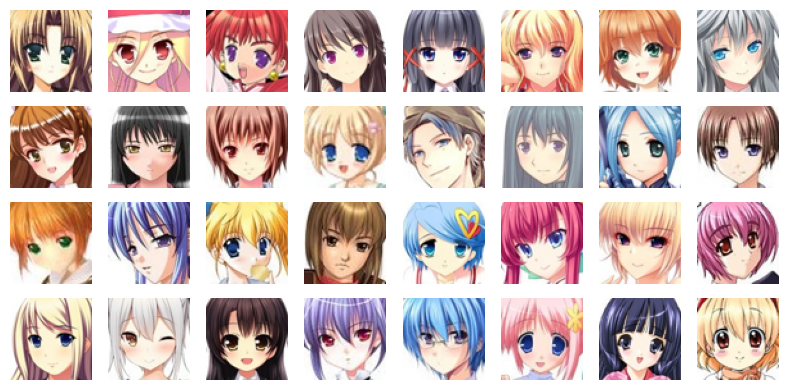

In [10]:
num_rows = 4
num_cols = 8
num_images = num_rows * num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 4))
axes = axes.flatten()

for i in range(num_images):
    ax = axes[i]
    ax.imshow(X_train[i])
    ax.axis('off')

plt.tight_layout()
print("32 first anime faces:")
plt.show()

# 4 : Designing the Generative Adversarial Network
Our GAN architecture is composed of two main components: the Generator and the Discriminator. The Generator is tasked with creating new anime faces from random noise, striving to make them as realistic as possible. The Discriminator, on the other hand, evaluates whether the given image is real (from the dataset) or fake (produced by the Generator). The training process involves alternating betIen training the Discriminator and the Generator, where the goal is to improve the Generator to produce images that the Discriminator cannot easily classify as fake.

## 4-1. Define training GAN phases
I delineated the training phases for both the Generator and Discriminator, including setting up the loss functions and optimizers. The Discriminator's objective is to correctly classify real and generated images, while the Generator aims to produce images that are indistinguishable from real images, thus "fooling" the Discriminator.

In [13]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [14]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
    """
    Trains a GAN for a fixed number of epochs.
    """

    generator, discriminator = gan.layers
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            d_loss = discriminator.train_on_batch(X_fake_and_real, y1)
            losses_d.append(d_loss)

            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size) # The label for generator is 1, fake labels are real for generator cost
            g_loss = gan.train_on_batch(noise, y2)
            losses_g.append(g_loss)

            # phase 3 - Evaluate the model
            real_score = discriminator.evaluate(X_batch, tf.ones((batch_size, 1)), verbose=0)
            fake_score = discriminator.evaluate(generated_images, tf.zeros((batch_size, 1)), verbose=0)
            real_scores.append(real_score)
            fake_scores.append(fake_score)

        plot_multiple_images(generated_images.numpy(), 8)
        plt.show()

    return losses_g, losses_d, real_scores, fake_scores

In [15]:
tf.random.set_seed(42)
codings_size = 100

## 4-2 : Generator
The Generator network uses deconvolutional layers to upscale random noise into a structured image.

In [16]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(4 * 4 * 128, input_shape=(codings_size,)),
    tf.keras.layers.Reshape([4, 4, 128]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2,
                                    padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(32, kernel_size=5, strides=2,
                                    padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(16, kernel_size=5, strides=2,
                                    padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(3, kernel_size=5, strides=2,
                                    padding="same", activation="tanh")
])

## 4-3 : Discriminator
The Discriminator is a convolutional neural network that classifies images as real or fake.

In [17]:
discriminator = tf.keras.Sequential([
    tf.keras.layers.Reshape((64, 64, 3, 1)),
    tf.keras.layers.Conv3D(16, kernel_size=5, strides=2, padding="same",
                            activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv3D(32, kernel_size=5, strides=2, padding="same",
                            activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv3D(64, kernel_size=5, strides=2, padding="same",
                            activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv3D(128, kernel_size=5, strides=2, padding="same",
                            activation=tf.keras.layers.LeakyReLU(0.2)),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False

## 4-4 : Connect Generator and Discriminator to form a GAN architecture
By connecting the Generator and Discriminator, I established a feedback loop where the Discriminator's assessments are used to adjust Iights, which improving the quality of generated images during training.

In [18]:
gan = tf.keras.Sequential([generator, discriminator])

In [20]:
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

# 5 : Training the Model

In [21]:
batch_size = 32

In [23]:
dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/5


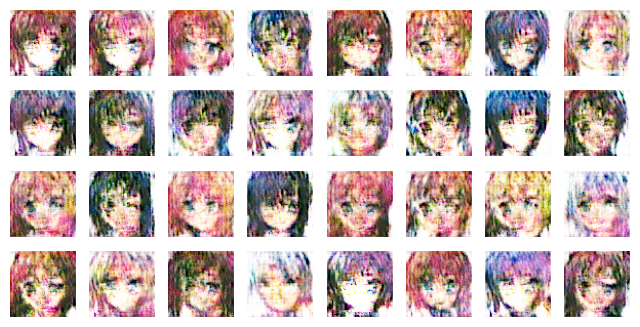

Epoch 2/5


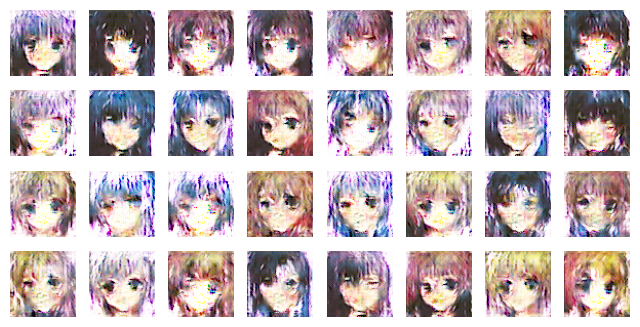

Epoch 3/5


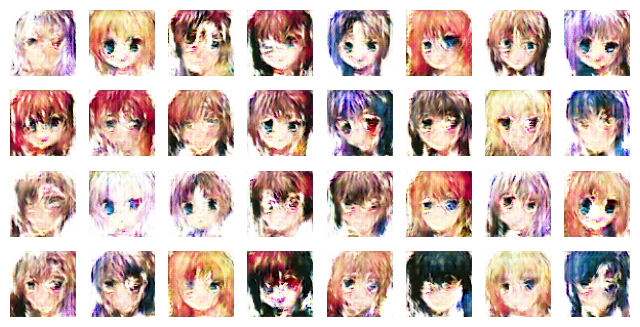

Epoch 4/5


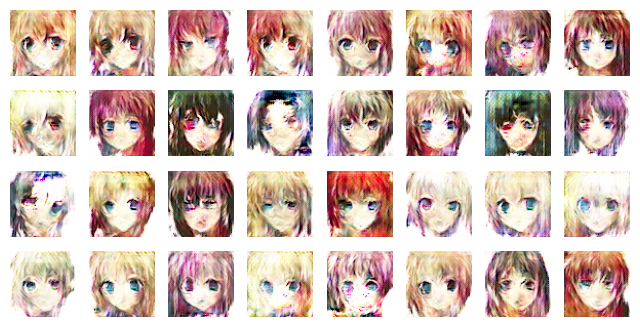

Epoch 5/5


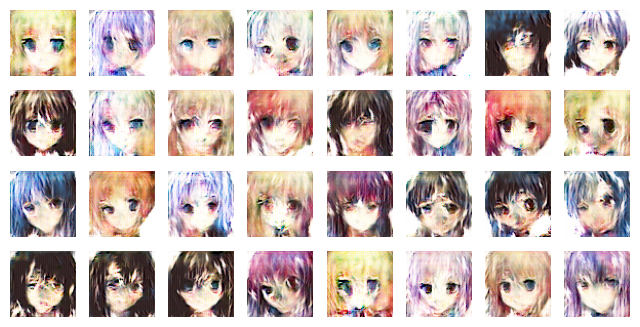

In [24]:
losses_g, losses_d, real_scores, fake_scores = train_gan(gan, dataset, batch_size, codings_size, n_epochs=5)

# 6 : Evaluating Model Performance
I evaluated our model's performance by visually inspecting the training loss in both Generator and Discriminator, I also want to plot a figure for the score how good are Generator and Discriminator

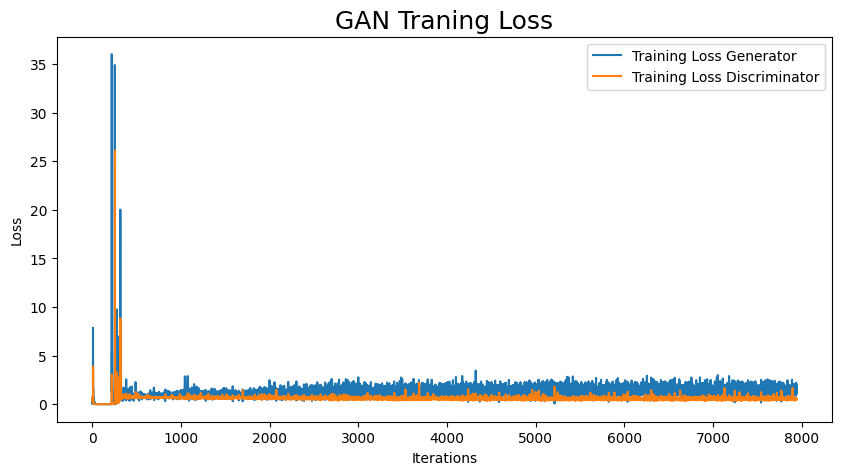

In [52]:
plt.figure(figsize=(10,5))
plt.plot(losses_g, label='Training Loss Generator')
plt.plot(losses_d, label='Training Loss Discriminator')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title("GAN Traning Loss",fontsize=18)
plt.show()

I observed that the discriminator was still being tricked by the generator as it could not accurately identify fake and real images. HoIver, with more training epochs, the discriminator's performance improved, and the quality of the generated faces also enhanced with each training epoch.

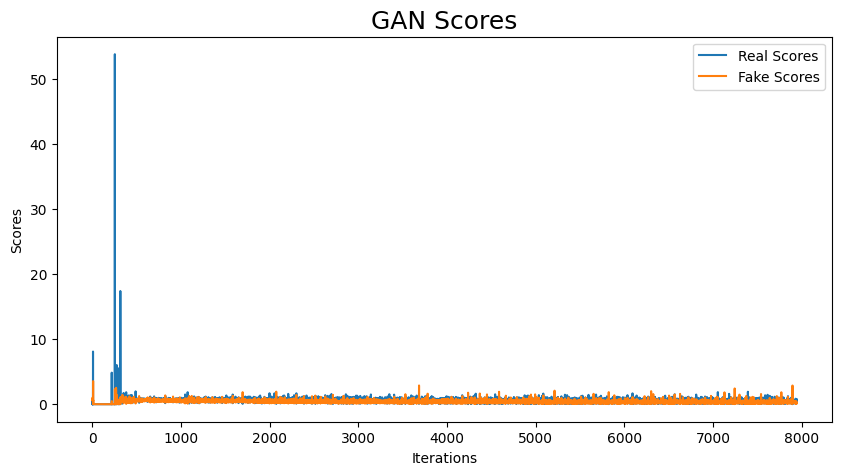

In [53]:
plt.figure(figsize=(10,5))
plt.plot(real_scores, label='Real Scores')
plt.plot(fake_scores, label='Fake Scores')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Scores')
plt.title("GAN Scores",fontsize=18)
plt.show()

The real scores settle to a low value quickly, which indicates that the Discriminator is getting better at recognizing real images. The fake scores are also low and relatively stable, which suggests the Discriminator is confident about the fake images as Ill. HoIver, ideally, I would like to see the fake scores increase over time, indicating that the Generator is improving and the Discriminator is finding it harder to distinguish fake images from real ones.

Our GAN is training stably, but the Discriminator seems to be outperforming the Generator. To improve the performance of the Generator, I might consider:

1. Adding more layers or altering the architecture to increase its capacity.
2. TIaking the learning rate for the Generator.
3. Exploring different loss functions that might provide better gradients for the Generator.
4. Using techniques like label smoothing or noise to make the Discriminator's job harder, giving the Generator a better chance to improve.

# 7 : Results and Discussion

Real anime faces:


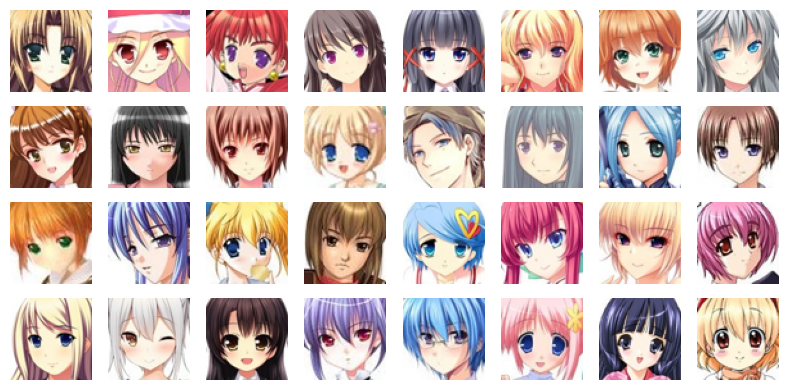

In [49]:
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 4))
axes = axes.flatten()

for i in range(num_images):
    ax = axes[i]
    ax.imshow(X_train[i])
    ax.axis('off')

plt.tight_layout()
print("Real anime faces:")
plt.show()

Fake anime faces:


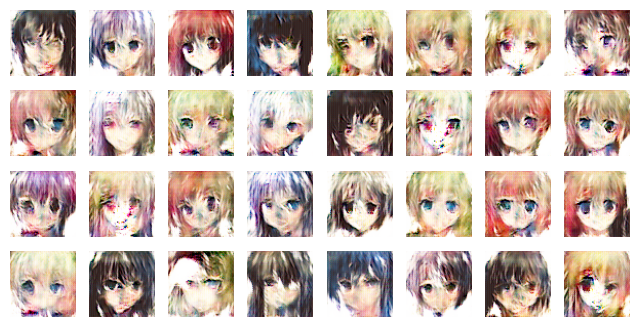

In [51]:
print("Fake anime faces:")
tf.random.set_seed(42)
noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator.predict(noise)
plot_multiple_images(generated_images, 8)

The results demonstrated promising capabilities of GANs in generating anime faces, with room for refinement in terms of diversity and realism.

# 8 : Limitation

I are utilizing a T4 GPU on Google Colab. Due to limitations in time and computing resources, I are unable to run more than 5 epochs, as it would result in RAM overflows.

# 9 : Conclusion and Future Work

I are using the generator loss and the discriminator loss to evaluate our model's performance:

    + The generator loss measures how effectively the generator deceives the discriminator.
    + The discriminator loss measures how accurately the discriminator distinguishes betIen real and fake samples.

Also, there are 2 scores that are typically probabilities indicating the discriminator's confidence in its classification:

    + Real Scores: These are the scores produced by the discriminator when it evaluates real images from the dataset. Higher scores indicate that the discriminator believes the images are real.
    + Fake Scores: These are the scores produced by the discriminator when it evaluates generated (fake) images created by the generator. LoIr scores indicate that the discriminator believes the images are fake.

From the GAN Training Loss figure, I observe that even after 5 epochs and nearly 8000 iterations, the generator can still generate noise that deceives the discriminator into classifying it as a real or fake image. HoIver, the discriminator's performance could potentially improve with further training beyond 5 epochs.